In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy import integrate
import geopy.distance
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import requests
import time
import math

import firebase_admin
from firebase_admin import credentials
from firebase_admin import firestore

In [2]:
# cred = credentials.Certificate('./../Backend/serviceAccount.json')
# app_firebase = firebase_admin.initialize_app(cred)
# db = firestore.client()

# read data

In [9]:
path = './ONLY_TEST/'
csv_files = glob.glob(os.path.join(path, "*.csv"))

df = {}

for f in csv_files:
    # print(f)
    if os.name == 'nt':
        filename = f.split('\\')[1]
    else:
        filename = f.split('/')[2]
    filename = filename[:-4]
    # print(filename)
    df[filename] = {}
df

{'AIQ3102-1670715240-schedule-0556': {},
 'TLM100-1671497100-schedule-0570': {},
 'AIQ512-1670716320-schedule-0609': {},
 'AIQ3223-1671878940-schedule-0501': {},
 'AIQ311-1670716320-schedule-0614': {},
 'AIQ3306-1671876960-schedule-0494': {},
 'TLM100-1671584040-schedule-0562': {},
 'AIQ3245-1671877800-schedule-0571': {},
 'TLM702-1670715240-schedule-0537': {},
 'TLM100-1671929100-schedule-0825': {}}

In [10]:
# #แก้
# df = {'AIQ3102-1670715240-schedule-0556':{},
#       'AIQ3223-1671878940-schedule-0501':{},
#       'AIQ3245-1671877800-schedule-0571':{},
#       'AIQ3306-1671876960-schedule-0494':{},}

In [11]:
#----- read flight data -----#
for key in df.keys():
    df[key]['df'] = pd.read_csv(f'ONLY_TEST/{key}.csv')
    df[key]['df'].drop(columns=['Unnamed: 0'],inplace=True)


In [12]:
for key in df.keys():
    aircraft = key.split('-')[0]
    print(aircraft)
    doc = db.collection('aircraft_engine').document(f'{aircraft}').get()
    if doc.exists:
        doc = doc.to_dict()
        air_type = doc['type']
        df[key]['ACFT_ID'] = air_type
        print(air_type)
        doc2 = db.collection('NPD_ID').document(f'{air_type}').get()
        if doc2.exists:
            doc2 = doc2.to_dict()
            df[key]['NPD_ID'] = doc2['NPD_ID']
        else: df[key]['NPD_ID']
    else: print('not found',aircraft)
        
        
    doc2 = db.collection('filter_flight').document(f'{key}').get()
    if doc2.exists:
        doc2 = doc2.to_dict()
        period = doc2['period']
        df[key]['period'] = period


AIQ3102
A320
TLM100
737-800
AIQ512
A320
AIQ3223
A320
AIQ311
A320
AIQ3306
A320
TLM100
737-800
AIQ3245
A320
TLM702
737-800
TLM100
737-800


In [13]:
df[key].keys()
df[key]['period']

'day'

In [14]:
df_fix_point = pd.read_csv('data/ANP2.2_Default_fixed_point_profiles.csv',delimiter=';')
df_fix_point = df_fix_point[df_fix_point['Stage Length'] == 1]
df_fix_point = df_fix_point[df_fix_point['Op Type'] == "A"]


change_type = {
    "A320" : "737800",
    "737-800" : "737800"
}

for key in df.keys():
    aircraft_type = df[key]["ACFT_ID"]
    if aircraft_type in change_type:
        aircraft_type = change_type[aircraft_type]
    else:
        df.pop(key)
        continue
    df[key]['df_fix_point'] = df_fix_point[df_fix_point.ACFT_ID == aircraft_type]
    df[key]['df_fix_point'] = df[key]['df_fix_point'].reset_index(drop=True)

In [15]:
df[key]['df_fix_point']

,ACFT_ID,Op Type,Profile_ID,Stage Length,Point Number,Distance (ft),Altitude AFE (ft),TAS (kt),Power Setting
0,737800,A,DEFAULT,1,1,-144240.0,6000.0,272.3,345.0
1,737800,A,DEFAULT,1,2,-135360.0,5542.0,270.5,332.0
2,737800,A,DEFAULT,1,3,-126540.0,5086.0,268.7,321.0
3,737800,A,DEFAULT,1,4,-113421.0,4405.0,266.1,315.0
4,737800,A,DEFAULT,1,5,-104748.0,3954.0,264.4,312.0
5,737800,A,DEFAULT,1,6,-96133.0,3505.0,262.7,307.0
6,737800,A,DEFAULT,1,7,-87574.0,3059.0,261.0,303.0
7,737800,A,DEFAULT,1,8,-86450.0,3000.0,260.8,303.0
8,737800,A,DEFAULT,1,9,-79300.0,3000.0,243.3,384.0
9,737800,A,DEFAULT,1,10,-71683.0,3000.0,224.1,479.0


# add power setting

In [16]:
def add_powersetting_2_flight(df_param, df_fixpoint):
    df__tmp = df_fixpoint.copy().groupby('TAS (kt)').max()
    df__tmp = df__tmp.reindex(df__tmp.index.union(df_param.groundspeed.unique()))
    df__tmp = df__tmp.interpolate(method='index',limit_direction='both',limit=200)
    df__tmp = df__tmp.reindex(df_param.groundspeed.unique())
    df__tmp.reset_index(drop=False, inplace=True)
    df__tmp.rename(columns={'TAS (kt)':'groundspeed'}, inplace=True)
    df__tmp = df__tmp[['groundspeed', 'Power Setting']]

    df_param = df_param.merge(df__tmp, how='left', on='groundspeed')
    
    return df_param

In [17]:
for key in df.keys():
    df[key]['df'] = add_powersetting_2_flight(df[key]['df'], df[key]['df_fix_point'])


In [18]:
df[key]['df']

,timestamp,fa_flight_id,altitude,groundspeed,heading,latitude,longitude,Power Setting
0,2022-12-27 00:55:41,TLM100-1671929100-schedule-0825,3.0000,171.0000,209.000000,13.899630,100.597450,754.884615
1,2022-12-27 00:55:42,TLM100-1671929100-schedule-0825,3.3125,171.6875,209.000000,13.898914,100.597042,751.673077
2,2022-12-27 00:55:43,TLM100-1671929100-schedule-0825,3.6250,172.3750,209.000000,13.898199,100.596634,748.500000
3,2022-12-27 00:55:44,TLM100-1671929100-schedule-0825,3.9375,173.0625,209.000000,13.897483,100.596226,745.326923
4,2022-12-27 00:55:45,TLM100-1671929100-schedule-0825,4.2500,173.7500,209.000000,13.896767,100.595817,742.153846
...,...,...,...,...,...,...,...,...
253,2022-12-27 00:59:54,TLM100-1671929100-schedule-0825,93.4000,304.2000,174.866667,13.692776,100.425710,345.000000
254,2022-12-27 00:59:55,TLM100-1671929100-schedule-0825,93.8000,304.4000,174.900000,13.691422,100.425835,345.000000
255,2022-12-27 00:59:56,TLM100-1671929100-schedule-0825,94.2000,304.6000,174.933333,13.690068,100.425960,345.000000
256,2022-12-27 00:59:57,TLM100-1671929100-schedule-0825,94.6000,304.8000,174.966667,13.688714,100.426085,345.000000


# creat npd data for flight

In [19]:
npd = pd.read_csv('data/ANP2.2_NPD_data.csv',delimiter=';', skiprows=[0])
npd.head()

,NPD_ID,Noise Metric,Op Mode,Power Setting,L_200ft,L_400ft,L_630ft,L_1000ft,L_2000ft,L_4000ft,L_6300ft,L_10000ft,L_16000ft,L_25000ft
0,2CF650,EPNL,A,10000.0,106.2,101.1,97.2,92.5,84.2,75.0,68.0,61.4,53.4,43.3
1,2CF650,EPNL,A,25000.0,109.8,105.1,101.5,97.3,90.3,82.0,76.0,70.0,62.7,53.9
2,2CF650,EPNL,D,25000.0,109.8,105.1,101.5,97.3,90.3,82.0,76.0,70.0,62.7,53.9
3,2CF650,EPNL,D,40000.0,113.0,108.6,105.2,101.5,95.6,88.2,83.1,77.5,70.8,63.3
4,2CF650,LAmax,A,10000.0,99.2,91.9,86.7,81.0,72.1,63.0,56.7,49.6,41.6,33.1


In [20]:
npd.columns

Index(['NPD_ID', 'Noise Metric', 'Op Mode', 'Power Setting', 'L_200ft',
       'L_400ft', 'L_630ft', 'L_1000ft', 'L_2000ft', 'L_4000ft', 'L_6300ft',
       'L_10000ft', 'L_16000ft', 'L_25000ft'],
      dtype='object')

In [21]:
def get_feet(distance):
    feet = distance.split('_')[1]
    return float(feet[:-2])

In [22]:
def npd_inter_per_flight(df_param, npd_id):
    npd_of_flight = npd[npd['NPD_ID'] == npd_id]
    npd_of_flight = npd_of_flight[npd_of_flight['Noise Metric'] == 'LAmax']
    npd_of_flight = npd_of_flight[npd_of_flight['Op Mode'] == 'A']
    npd_of_flight.set_index('Power Setting', inplace=True)

    npd_of_flight = npd_of_flight.reindex(npd_of_flight.index.union(df_param['Power Setting'].unique()))
    npd_of_flight = npd_of_flight.interpolate(method='index',limit_direction='both',limit=200)
    
    npd_of_flight = npd_of_flight.drop(columns=['NPD_ID','Noise Metric','Op Mode']).T.reset_index()
    npd_of_flight.rename(columns={'index':'distance'},inplace=True)

    npd_of_flight['distance'] = npd_of_flight['distance'].apply(get_feet)
    npd_of_flight.set_index('distance',inplace=True)
    return npd_of_flight

In [23]:
for key in df.keys():
    df[key]['npd'] = npd_inter_per_flight(df[key]['df'], df[key]['NPD_ID'])

In [24]:
# df[key]['npd']

# cal grid

In [25]:
#----- calculate distance from lat, long -----#
def add_distance(lat1, long1, lat2, long2, h2):
    position1 = (lat1,long1)
    position2 = (lat2,long2)
    a = geopy.distance.geodesic(position1, position2).ft
    b = h2
    b = b*100
    c_square = a**2 + b**2
    c = math.sqrt(c_square)
    return c

In [26]:
#----- function Single Soung Event -----#
def function_L(sound) :
    return 10**(sound / 10)

In [27]:
# 13.911475, 100.605997 DMK
# 50 ช่อง -> เพิ่มทีละ 0.004
100.505997, 100.705997
13.811475, 14.011475

(13.811475, 14.011475)

In [28]:
lat_start =  13.811475
long_start = 100.505997
L_dB_start = 0
size = 50

def create_observerer():
    global lat_start, long_start, L_dB_start
    observer = np.zeros((size,size,3))
    for i in range(size) :
        for j in range(size) :
            observer[i][j] = lat_start, long_start, L_dB_start
            long_start += 0.004
        lat_start  += 0.004
        long_start = 100.505997
    lat_start =  13.811475    
    return observer

In [29]:
for key in df.keys():
    df[key]['grid'] = create_observerer()

In [30]:
def Calculate_Grid(observer,df_param, npd_param):
    for i in range(len(observer)):
        for j in range(len(observer[i])): # j = [lat, long, L(dB)]
            #----- copy df_param -----#
            tmp = df_param.copy()
            
            #----- calculate distance every transection -----#
            tmp_distance = []
            tmp['distance'] = -1
            
            for index, row in tmp.iterrows():
                distance = add_distance(observer[i][j][0], observer[i][j][1], row['latitude'], row['longitude'], row['altitude'])
                # print(distance)
                tmp_distance.append(distance)
                tmp.loc[index, 'distance'] = distance
            
            #----- calculate L_dB from powersetting & distance -> copy to model_data -----#
            npd_after_inter = npd_param.reindex(npd_param.index.union(tmp_distance))
            npd_after_inter = npd_after_inter.interpolate(method='index',limit_direction='both',limit=200)
            model_data = npd_after_inter.copy()
            
            #----- add L_dB to df['sound'] & select < 25000 only -----#
            for index, row in tmp.iterrows():
                tmp.loc[index,'sound'] = model_data.loc[row.distance,row['Power Setting']]
                
            # tmp = tmp[tmp['distance']<30000]
            
            #----- Single Sound Event Model -----#
            if tmp.empty:
                continue
            tmp['Function'] = tmp['sound'].apply(function_L)
            area = integrate.simpson(tmp['Function'])
            #----- change -inf -> 0 -----#
            if area == 0:
                lSEL = 0
            else:
                lSEL = 10*np.log10( (1/1)*area)
            
            #----- add l_dB to observer -----#
            observer[i][j][2] = lSEL
            
    return observer

In [31]:
for key in df.keys():
    df[key]['grid'] = Calculate_Grid(df[key]['grid'], df[key]['df'], df[key]['npd'])

In [32]:
#----- observer to pivot table -----#
for key in df.keys():
    df_tmp = pd.DataFrame(columns = ['Lat','Long','L_dB'])
    
    #----- matrix to pandas -----#
    for i in range(len(df[key]['grid'])):
        row = pd.DataFrame(df[key]['grid'][i], columns = ['Lat','Long','L_dB'])
        df_tmp = pd.concat([df_tmp, row])
    
    #----- Create pivot table -----#
    tabal_df = pd.pivot_table(df_tmp,index='Lat',columns='Long',values='L_dB')
    df[key]['grid'] = tabal_df
    df[key]['grid'] = df[key]['grid'].iloc[::-1]

In [33]:
df.keys()

dict_keys(['AIQ3102-1670715240-schedule-0556', 'TLM100-1671497100-schedule-0570', 'AIQ512-1670716320-schedule-0609', 'AIQ3223-1671878940-schedule-0501', 'AIQ311-1670716320-schedule-0614', 'AIQ3306-1671876960-schedule-0494', 'TLM100-1671584040-schedule-0562', 'AIQ3245-1671877800-schedule-0571', 'TLM702-1670715240-schedule-0537', 'TLM100-1671929100-schedule-0825'])

In [34]:
df['AIQ512-1670716320-schedule-0609'].keys()

dict_keys(['df', 'ACFT_ID', 'NPD_ID', 'period', 'df_fix_point', 'npd', 'grid'])

In [35]:
# df['AIQ512-1670716320-schedule-0609']['npd']

In [36]:
# df['AIQ311-1670716320-schedule-0614']['grid']

In [37]:
# df['AIQ512-1670716320-schedule-0609']['grid'].iloc[::-1]

In [38]:
tmp_grid = df['AIQ311-1670716320-schedule-0614']['grid'].T
# tmp_grid = df['AIQ512-1670716320-schedule-0609']['grid'].T

# tmp_grid.isnull().sum()

In [39]:
# tmp_grid

In [40]:
# for i in tmp_grid.columns:
    # if (tmp_grid[i] == 0).all():
    #     print(f"All values in the column {i} are Zero")
    # print((tmp_grid[i] == -np.inf).sum())

count = np.isinf(tmp_grid).values.sum()
print("It contains " + str(count) + " infinite values")
    



It contains 0 infinite values


In [41]:
arr = tmp_grid.to_numpy()
# np.argwhere(arr == 0).sum()
np.count_nonzero(arr)

1667

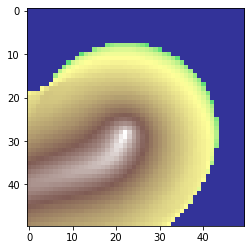

In [42]:
import matplotlib as mpl
plt.imshow(df['AIQ512-1670716320-schedule-0609']['grid'], cmap='terrain')
plt.show()

In [43]:
#----- save to csv -----#
for key in df.keys():
    tmp_grid = df[key]['grid'].to_csv(f'grid_flights/{key}.csv', index = True)

# cumulative

In [2]:
df = {}

path = './test_cumu/'
csv_files = glob.glob(os.path.join(path, "*.csv"))

df = {}

for f in csv_files:
    # print(f)
    if os.name == 'nt':
        filename = f.split('\\')[1]
    else:
        filename = f.split('/')[2]
    filename = filename[:-4]
    # print(filename)
    df[filename] = {}
df

{'AIQ3102-1670715240-schedule-0556': {}, 'AIQ311-1670716320-schedule-0614': {}}

In [3]:
#----- read flight data -----#
for key in df.keys():
    if key != 'test_flight':
        df[key]['grid'] = pd.read_csv(f'test_cumu/{key}.csv', index_col='Lat')
        df[key]['period'] = 'day'

In [3]:
mockup_api = ['AIQ311-1670716320-schedule-0614','AIQ3102-1670715240-schedule-0556']

df = {}
for flight in mockup_api:
    df[flight] = {}
    doc_ref3 = db.collection('detail_and_grid').document('grid').collection(f'{flight}')
    docs2 = list(doc_ref3.stream())
    flight_dict2 = list(map(lambda x: x.to_dict(), docs2))
    df2 = pd.DataFrame(flight_dict2)
    if not df2.empty:
        df[flight] = {}
        # df2 = pd.melt(df2, id_vars=['Lat'], value_vars=df2.drop(columns=['Lat']).columns)
        # df2.rename(columns={'variable':'Long'},inplace=True)
        df2.set_index('Lat',inplace=True)
        df2.sort_index(ascending=False,inplace=True)
        col = list(df2.columns)
        col.sort()
        df2 = df2[col]

        df[flight]['grid'] = df2.copy()
        df[flight]['period'] = 'day'


In [25]:
df[flight]['grid'] 

,100.505997,100.509997,100.513997,100.51799700000001,100.52199700000001,100.52599700000002,100.52999700000002,100.53399700000003,100.53799700000003,100.54199700000004,...,100.66599700000019,100.6699970000002,100.6739970000002,100.6779970000002,100.68199700000021,100.68599700000021,100.68999700000022,100.69399700000022,100.69799700000023,100.70199700000023
Lat,,,,,,,,,,,,,,,,,,,,,
14.007475,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14.003475,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13.999475,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13.995475,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13.991475,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13.987475,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13.983475,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13.979475,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13.975475,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df['AIQ311-1670716320-schedule-0614']['grid']

,100.505997,100.509997,100.513997,100.51799700000001,100.52199700000001,100.52599700000002,100.52999700000002,100.53399700000003,100.53799700000003,100.54199700000004,...,100.66599700000019,100.6699970000002,100.6739970000002,100.6779970000002,100.68199700000021,100.68599700000021,100.68999700000022,100.69399700000022,100.69799700000023,100.70199700000023
Lat,,,,,,,,,,,,,,,,,,,,,
14.007475,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
14.003475,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
13.999475,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
13.995475,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
13.991475,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
13.987475,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
13.983475,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
13.979475,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
13.975475,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [16]:
# #----- read from database -----#

# doc_ref3 = db.collection('detail_and_grid').document('grid').collection(f'{id}')
# docs2 = list(doc_ref3.stream())
# flight_dict2 = list(map(lambda x: x.to_dict(), docs2))
# df2 = pd.DataFrame(flight_dict2)

ValueError: The default Firebase app does not exist. Make sure to initialize the SDK by calling initialize_app().

In [4]:
# df['AIQ311-1670716320-schedule-0614']['grid'] = pd.read_csv('grid_flights/AIQ311-1670716320-schedule-0614.csv')
# df['AIQ311-1670716320-schedule-0614']['period'] = 'day'

# df['AIQ3102-1670715240-schedule-0556']['grid'] = pd.read_csv('grid_flights/AIQ3102-1670715240-schedule-0556.csv')
# df['AIQ3102-1670715240-schedule-0556']['period'] = 'day'
df['AIQ311-1670716320-schedule-0614']['grid'].tail()

,100.505997,100.509997,100.513997,100.51799700000001,100.52199700000001,100.52599700000002,100.52999700000002,100.53399700000003,100.53799700000003,100.54199700000004,...,100.66599700000019,100.6699970000002,100.6739970000002,100.6779970000002,100.68199700000021,100.68599700000021,100.68999700000022,100.69399700000022,100.69799700000023,100.70199700000023
Lat,,,,,,,,,,,,,,,,,,,,,
13.827475,64.391737,63.969892,63.576467,63.206432,62.858036,62.521577,62.204334,61.914982,61.646396,61.374325,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13.823475,62.716103,62.291028,61.920768,61.599490,61.308712,61.026488,60.746119,60.468128,60.189350,59.898882,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13.819475,61.261277,60.888887,60.537810,60.214313,59.905813,59.605361,59.313808,59.027833,58.738362,58.447185,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13.815475,59.953857,59.549245,59.174754,58.834610,58.510384,58.202467,57.914409,57.622626,57.335413,57.051153,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13.811475,58.655222,58.230059,57.845507,57.494957,57.170035,56.870112,56.587772,56.311010,56.048788,55.812476,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
#----- result grid for plot -----#
# res_grid = np.zeros((50,50))
res_grid = [[0 for x in range(50)] for y in range(50)]

In [6]:
#----- Variable Value for Cumulative Level ( Day-Night ) -----#
Day_Delta_i = 0
Night_Delta_i = 10
t0 = 1
T0 = 3

In [7]:
#----- function Cumulative Level ( Day-Night ) -----#
def Cumulative_model(DN, sound):
    global Day_Delta_i, Night_Delta_i
    if DN == 'night':
        return 3 * (10**( (sound + Night_Delta_i) / 10 ))
    elif DN == 'day':
        return 3 * (10**( (sound + Day_Delta_i) / 10 ))
    else:
        return 0

In [29]:
# #----- function Cumulative Level ( Day-Night ) -----#
# def Cumulative_model(DN, sound, duration_day, duration_night):
#     global Day_Delta_i, Night_Delta_i
#     if DN == 'night':
#         return duration_night * (10**( (sound + Night_Delta_i) / 10 ))
#     elif DN == 'day':
#         return duration_day * (10**( (sound + Day_Delta_i) / 10 ))
#     else:
#         return 0

In [13]:
#ไม่ได้ใช้
# duration_day =1
# duration_night =2
# df={
#     'day':{
#         'key1':{'grid': pd.DataFrame},
#         'key2':{'grid': pd.DataFrame},

#     },
#     'night':{}
# }

In [8]:
for i in range(len(df[list(df.keys())[0]]['grid'])):
    for j in range(len(df[list(df.keys())[0]]['grid'])):
        LDN = 0
        for key in df.keys():
            LDN = LDN + Cumulative_model(df[key]['period'], df[key]['grid'].iloc[i, j])
            # LDN = LDN + Cumulative_model(df[key]['period'], df[key]['grid'].iloc[i, j], duration_day, duration_night)
        res_grid[i][j] = 10*np.log10( (t0 / T0) * LDN )

In [9]:
res_grid[0:2][0:2]

[[3.010299956639812,
  3.010299956639812,
  3.010299956639812,
  3.010299956639812,
  3.010299956639812,
  3.010299956639812,
  3.010299956639812,
  3.010299956639812,
  3.010299956639812,
  3.010299956639812,
  3.010299956639812,
  3.010299956639812,
  3.010299956639812,
  3.010299956639812,
  3.010299956639812,
  3.010299956639812,
  3.010299956639812,
  3.010299956639812,
  3.010299956639812,
  3.010299956639812,
  3.010299956639812,
  3.010299956639812,
  3.010299956639812,
  3.010299956639812,
  3.010299956639812,
  3.010299956639812,
  3.010299956639812,
  3.010299956639812,
  3.010299956639812,
  3.010299956639812,
  3.010299956639812,
  3.010299956639812,
  3.010299956639812,
  3.010299956639812,
  3.010299956639812,
  3.010299956639812,
  3.010299956639812,
  3.010299956639812,
  3.010299956639812,
  3.010299956639812,
  3.010299956639812,
  3.010299956639812,
  3.010299956639812,
  3.010299956639812,
  3.010299956639812,
  3.010299956639812,
  3.010299956639812,
  3.010299956

In [31]:
# index = db.collection('NPD_ID').create_index([('ACFT_ID',)])
# print(index)

AttributeError: 'CollectionReference' object has no attribute 'create_index'